# read CAID2 predictions

100%|██████████| 72/72 [00:07<00:00,  9.32it/s]
/tmp/ipykernel_1455480/2149555021.py:190: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, 1/(2/i-1/x), color='lightgray', lw=1, linestyle='--', alpha=0.5)


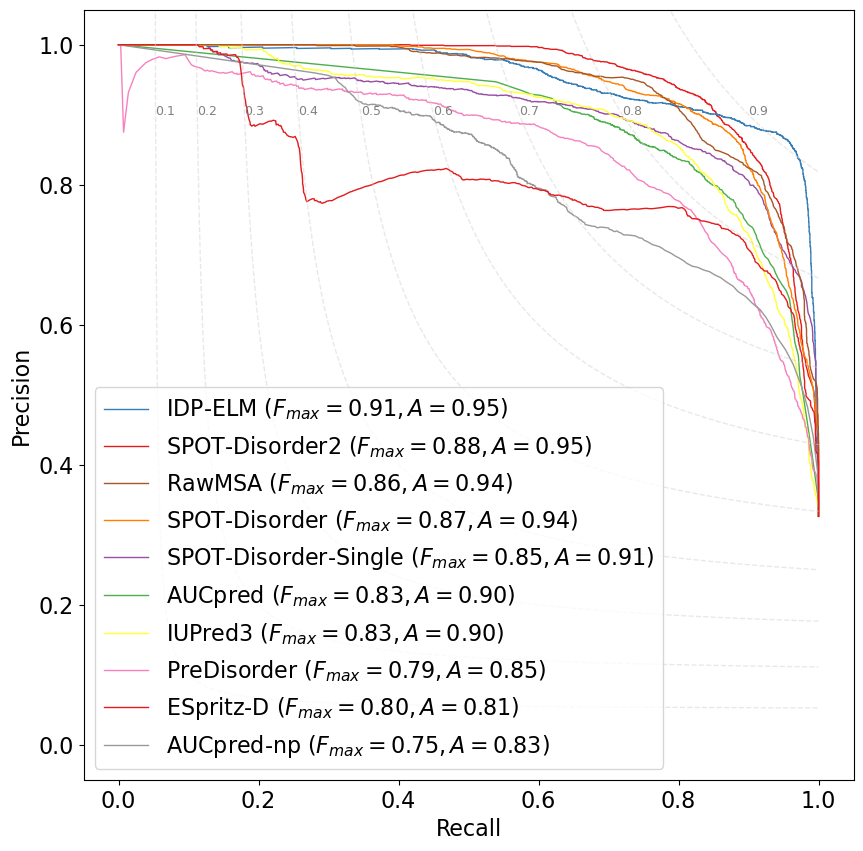

In [5]:
from pathlib import Path
import numpy as np
import seaborn as sns


import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, f1_score, matthews_corrcoef, recall_score, precision_score, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
# t_test
from scipy.stats import ttest_ind

pal = sns.color_palette("Set1", 34)
pal.append('red')

def read_actual():
    lines = open('../CAID2_clean.txt').read().splitlines()
    # lines = open('disorder_pdb_2.txt').read().splitlines()
    # lines = open('CAID2.txt').read().splitlines()

    seqs = {}
    for i in range(0, len(lines), 3):
        seqid = lines[i].strip()[1:]
        seq = lines[i+1].strip()
        dis = np.array([int(i) for i in lines[i+2]])
        seqs[seqid] = (seq, dis)
    return seqs

def read_results(p):
    lines = [l for l in open(p).read().split('>') if l.strip()]
    seqs = {}
    for line in lines:
        line = line.splitlines()
        seqid = line[0].strip()

        try:
            aa_idx, aa, prob, pred = zip(*[l.split('\t') for l in line[1:]])
            pred = np.array([int(i) for i in pred])
        except:
            aa_idx, aa, prob, *_ = zip(*[l.split('\t') for l in line[1:]])
            pred = None
            
        seq = ''.join(aa)
        if ''.join(prob).strip() == '':
            prob = None
        else:
            prob = np.array([float(i) for i in prob])
        
        seqs[seqid] = (seq, prob, pred)
    return seqs


fig = plt.figure(figsize=(10, 10))
df = pd.DataFrame(columns=['Predictor', 'ROC AUC', 'F1', 'MCC', 'Recall', 'Precision', 'Failed', "P-value"])


order = []
actual = read_actual()
names = ['IDP-ELM', 'SPOT-Disorder2', 'rawMSA', 'SPOT-Disorder', 'SPOT-Disorder-Single', 'AUCpred-profile', 'IUPred3', 'PreDisorder', 'ESpritz-D', 'AUCpred-no-profile']
failed_set = set()

# read IDP-PLM
baseline = read_results(Path('predictions/IDP-ELM.caid'))
probs, preds, labels = [], [], []
failed = 0
for seqid in actual:
    if seqid in failed_set:
        continue
    seq, dis = actual[seqid]
    if seqid not in baseline:
        print(f"No prediction for {seqid} in {file}")
        failed_set.add(seqid)
        failed += 1
        continue

    seq2, prob, pred = baseline[seqid]
    assert seq == seq2, f"{file}: {seqid} {len(seq)} {len(seq2)}"
    probs.append(prob)
    preds.append(pred)
    labels.append(dis)

base_labels = np.concatenate(labels)
base_mask = (base_labels != 2).astype(bool)
base_labels = base_labels[base_mask]
base_probs = np.concatenate(probs)
base_probs = base_probs[base_mask]
base_preds = np.concatenate(preds)
base_preds = base_preds[base_mask]

plt.rcParams.update({'font.size': 16})
for file in tqdm(list(Path('predictions').glob("*.caid"))):
    predicotr_name = file.stem

    if predicotr_name not in names:
        continue
    try:
        predictions = read_results(file)
    except:
        print(f"Failed to read {file}")
        continue
    probs, preds, labels = [], [], []
    failed = 0

    for seqid in actual:
        if seqid in failed_set:
            continue

        seq, dis = actual[seqid]

        if seqid not in predictions:
            # print(f"No prediction for {seqid} in {file}")
            failed_set.add(seqid)

            failed += 1
            continue

        seq2, prob, pred = predictions[seqid]
        assert seq == seq2, f"{file}: {seqid} {len(seq)} {len(seq2)}"

        probs.append(prob)
        preds.append(pred)
        labels.append(dis)

    labels = np.concatenate(labels)
    mask = (labels != 2).astype(bool)
    labels = labels[mask]

    if probs[0] is not None:
        probs = np.concatenate(probs)
        probs = probs[mask]

        if preds[0] is not None:
            preds = np.concatenate(preds)
            preds = preds[mask]
        else:
            preds = probs > 0.5

        order.append(names.index(predicotr_name))
        # do t test and get p value
        t, p = ttest_ind(base_probs, probs)

        df.loc[len(df)] = [predicotr_name, roc_auc_score(labels, probs), f1_score(labels, preds), matthews_corrcoef(labels, preds), recall_score(labels, preds), precision_score(labels, preds), failed, p]

        if predicotr_name == 'rawMSA':
            _predicotr_name = 'RawMSA'
        elif predicotr_name == 'AUCpred-profile':
            _predicotr_name = 'AUCpred'
        elif predicotr_name == 'AUCpred-no-profile':
            _predicotr_name = 'AUCpred-np'
        else:
            _predicotr_name = predicotr_name


        # fpr, tpr, _ = roc_curve(labels, probs)
        # roc_auc = auc(fpr, tpr)
        # plt.plot(fpr, tpr, lw=1, label=f'{_predicotr_name} ($A={roc_auc:.2f}$)',)

        precision, recall, _ = precision_recall_curve(labels, probs)
        pr_auc = auc(recall, precision)
        # ignore nan
        fs = 2 * precision * recall / (precision + recall)
        f_max = np.max(fs[~np.isnan(fs)])
        plt.plot(recall, precision, lw=1, color=pal[len(df)-1], label=f'{_predicotr_name} ($F_{{max}}={f_max:.2f}, A={pr_auc:.2f}$)')

    else:
        preds = np.concatenate(preds)
        preds = preds[mask]
        # do t test and get p value
        # t, p = ttest_ind(base_preds, preds)

        df.loc[len(df)] = [predicotr_name, np.nan, f1_score(labels, preds), matthews_corrcoef(labels, preds), recall_score(labels, preds), precision_score(labels, preds), failed, p]



handles, ls = plt.gca().get_legend_handles_labels()
plt.legend([handles[order.index(i)] for i in range(len(order))],[ls[order.index(i)] for i in range(len(order))], fontsize=16, loc='lower left',)
# # add title, x and y labels################################################
# plt.title('Receiver Operating Characteristic', fontsize=16)

# # draw legend with the name of chosen_list #################### 
# plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
# plt.xlabel('False Positive Rate', fontsize=14)
# plt.ylabel('True Positive Rate', fontsize=14)

#################### PR AUC ####################

for i in np.arange(0.1, 1, 0.1):
    # draw 2*x*y / (x+y) = i
    x = np.linspace(i/2, 1, 1000)
    plt.plot(x, 1/(2/i-1/x), color='lightgray', lw=1, linestyle='--', alpha=0.5)
    plt.annotate(f'{i:.1f}', ( 1/(2/i-1/0.9), 0.9), color='gray', fontsize=9)
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
# no white grid
plt.grid(color='white', linestyle='-', linewidth=0.5)
# # set x axis length same as y axis
plt.gca().set_aspect('equal', adjustable='box')
# draw the line for AUC = 0.5, 0.6, 0.7, 0.8, 0.9
plt.show()

# print(failed_set)

In [6]:
# sort df by ROC AUC togather with other metrics
df = df.sort_values(by=['ROC AUC', 'F1', 'MCC', 'Recall', 'Precision'], ascending=False)
# print the first 10 rows' predictor as a list
print(df['Predictor'].tolist()[0:10])
# show with 3 decimal places and the predictors in a list
print(failed_set)

available_set = actual.keys() - failed_set
print(f"Available: {len(available_set)}")
df.round(4)

['IDP-ELM', 'SPOT-Disorder2', 'rawMSA', 'SPOT-Disorder', 'SPOT-Disorder-Single', 'AUCpred-profile', 'IUPred3', 'PreDisorder', 'ESpritz-D', 'AUCpred-no-profile']
{'DP02686', 'DP03626', 'DP03379', 'DP03743', 'DP03277', 'DP03446', 'DP03581', 'DP02844', 'DP02376', 'DP02953', 'DP02567', 'DP02627', 'DP02401', 'DP02977'}
Available: 25


,Predictor,ROC AUC,F1,MCC,Recall,Precision,Failed,P-value
1,IDP-ELM,0.9775,0.9050,0.8577,0.9369,0.8751,0,0.0000
0,SPOT-Disorder2,0.9711,0.8779,0.8223,0.8516,0.9059,14,0.7898
6,rawMSA,0.9682,0.8501,0.7785,0.8426,0.8576,0,0.0000
4,SPOT-Disorder,0.9655,0.8674,0.8062,0.8454,0.8906,0,0.0000
3,SPOT-Disorder-Single,0.9580,0.7327,0.6640,0.6095,0.9184,0,0.0000
2,AUCpred-profile,0.9417,0.7984,0.7154,0.7425,0.8633,0,0.0000
5,IUPred3,0.9394,0.8261,0.7465,0.8012,0.8526,0,0.0000
7,PreDisorder,0.9192,0.7706,0.6502,0.8742,0.6890,0,0.0000
9,ESpritz-D,0.9159,0.3971,0.3677,0.2599,0.8413,0,0.0000
8,AUCpred-no-profile,0.9062,0.6448,0.5616,0.5156,0.8604,0,0.0000


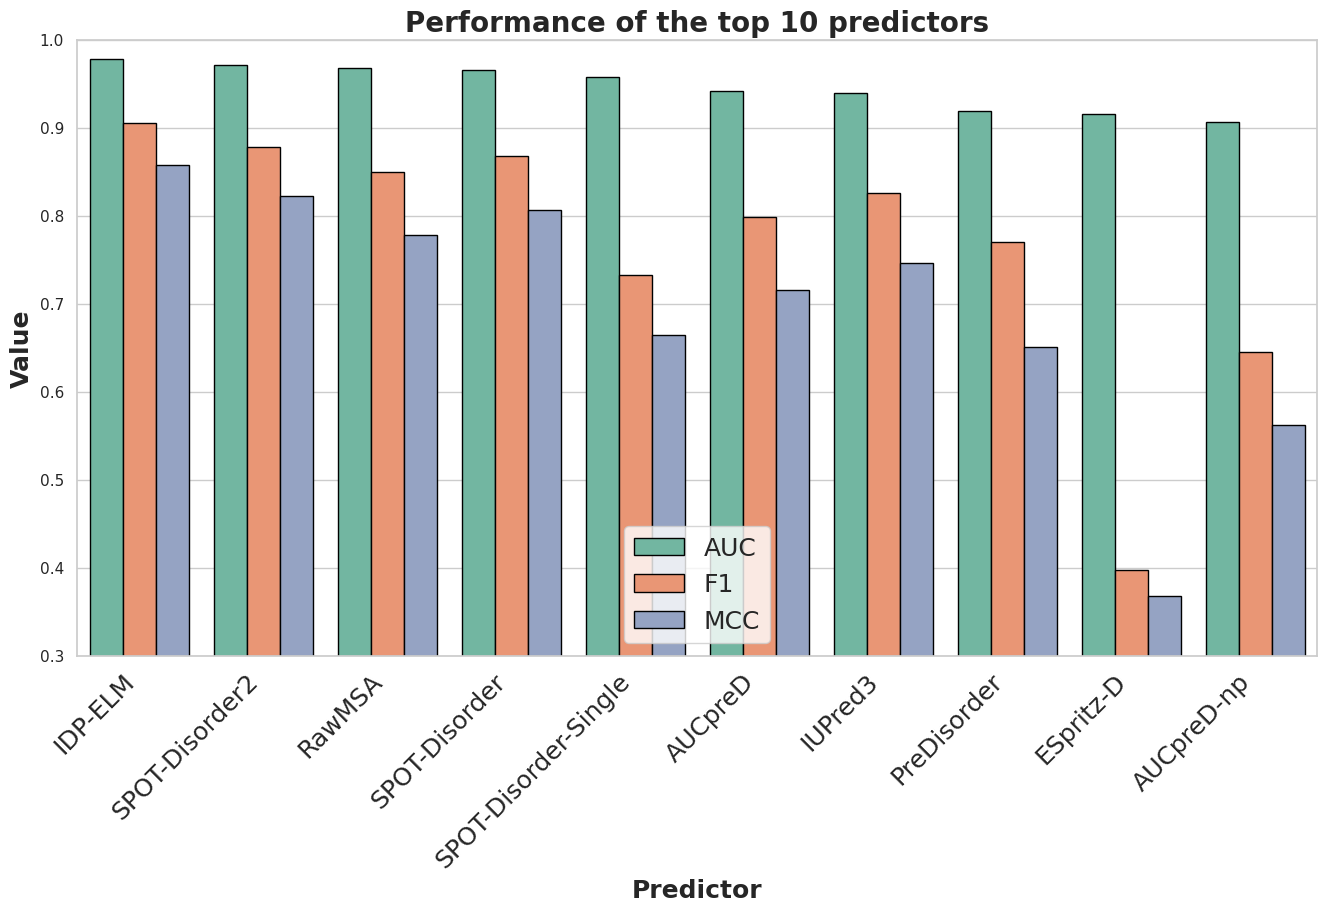

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
# dpi
pal = sns.color_palette("Set2", len(df))
# df select AUC, F1, and MCC as metrics
_df = df[['Predictor', 'ROC AUC', 'F1', 'MCC']].sort_values(by=['ROC AUC', 'F1', 'MCC'], ascending=False)
# replace Predictor with following dict
pred_names = {
    "rawMSA": "RawMSA",
    "AUCpred-profile" : "AUCpreD",
    "AUCpred-no-profile" : "AUCpreD-np",
}
_df['Predictor'] = _df['Predictor'].replace(pred_names)
# rename "ROC AUC" to "AUC"
_df = _df.rename(columns={"ROC AUC": "AUC"})
# draw grouped bars including three metrics AUC, F1, and MCC for the first 10 rows
ax = sns.barplot(x="Predictor", y="value", hue="variable", data=pd.melt(_df.head(10), ['Predictor']), palette=pal, linewidth=1, edgecolor='black')
# set y axis range
ax.set(ylim=(0.3, 1.0))
# set title, x and y labels
plt.title('Performance of the top 10 predictors', fontsize=20, fontweight='bold')
plt.xlabel('Predictor', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.legend(loc='lower center', fontsize=18)
# x axis label rotate 45 degree, fontsize 18
plt.xticks(rotation=45, fontsize=18,  ha='right')
# plot box black line width 2
sns.set_style("whitegrid", {'axes.linewidth': 2})

In [15]:
content = open('../CAID2_clean.txt').read().splitlines()
# content = open('disorder_pdb_2.txt').read().splitlines()
labels = [content[i+2] for i in range(0, len(content), 3) if content[i] not in failed_set]
pos = sum([l.count('1') for l in labels])
neg = sum([l.count('0') for l in labels])
mask = sum([l.count('2') for l in labels])

print(f"Positive: {pos / (pos + neg + mask)}, Negative: {neg / (pos + neg + mask)}, Mask: {mask / (pos + neg + mask)}")
print(f"Positive: {pos}, Negative: {neg}, Mask: {mask}")
print(len(labels))

Positive: 0.10476831545576931, Negative: 0.29484952447127283, Mask: 0.6003821600729579
Positive: 4825, Negative: 13579, Mask: 27650
39
